# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Check GPU Resources

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


#Check CPU Resources

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 40
core id		: 0
cpu cores	: 20
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virt

In [ ]:
!cat /proc/meminfo

MemTotal:       36949444 kB
MemFree:        18297904 kB
MemAvailable:   34508708 kB
Buffers:          226900 kB
Cached:         15971616 kB
SwapCached:            0 kB
Active:          2322188 kB
Inactive:       15240952 kB
Active(anon):       1060 kB
Inactive(anon):  1364984 kB
Active(file):    2321128 kB
Inactive(file): 13875968 kB
Unevictable:          16 kB
Mlocked:              16 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               212 kB
Writeback:             0 kB
AnonPages:       1364592 kB
Mapped:           373052 kB
Shmem:              1396 kB
KReclaimable:     511792 kB
Slab:             674940 kB
SReclaimable:     511792 kB
SUnreclaim:       163148 kB
KernelStack:       14892 kB
PageTables:        32508 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    18474720 kB
Committed_AS:    8520012 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       19372 kB
VmallocChunk:          0 kB
Percpu:          

#Install AutoTime to Measure the runtime

In [ ]:
!pip install ipython-autotime hypopt
%load_ext autotime

time: 290 µs (started: 2023-12-13 02:06:28 +00:00)


# Import Libraries

In [ ]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from joblib import dump, load
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
import numpy as np
import itertools

from time import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


time: 2.4 s (started: 2023-12-13 02:06:28 +00:00)


# Common Methods

## Plot The Confusion Matrix

In [ ]:
## https://github.com/parthpatwa/covid19-fake-news-detection/blob/main/ml_baseline-test.ipynb
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

time: 1.08 ms (started: 2023-12-13 02:06:31 +00:00)


In [ ]:
stops = set(stopwords.words("english"))
def cleantext(string):
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+",' ',text)
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)
    tx = text.replace('&amp',' ')
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.split()
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

time: 2.69 ms (started: 2023-12-13 02:06:31 +00:00)


# Import Dataset and Define the Random State

In [ ]:
PATH = '/content/drive/MyDrive/UNS/dataset/'
train = pd.read_csv(PATH + 'Constraint_Train.csv')
val = pd.read_csv(PATH + 'Constraint_Val.csv')
test = pd.read_csv(PATH + 'english_test_with_labels.csv')

RANDOM_STATE = 21

time: 2.32 s (started: 2023-12-13 02:06:31 +00:00)


In [ ]:
train['tweet'] = train['tweet'].map(lambda x: cleantext(x))
train ['label'] = train['label'].map(lambda x: cleantext(x))
val['tweet'] = val['tweet'].map(lambda x: cleantext(x))
val['label'] = val['label'].map(lambda x: cleantext(x))
test['tweet'] = test['tweet'].map(lambda x: cleantext(x))
test ['label'] = test['label'].map(lambda x: cleantext(x))
new_train = train['label']

time: 322 ms (started: 2023-12-13 02:06:33 +00:00)


In [ ]:
print(train['label'])
print(train['tweet'])

0       real
1       real
2       fake
3       real
4       real
        ... 
6415    fake
6416    fake
6417    fake
6418    fake
6419    real
Name: label, Length: 6420, dtype: object
0       cdc currently reports 99031 deaths general dis...
1       states reported 1121 deaths small rise last tu...
2       politically correct woman almost uses pandemic...
3       indiafightscorona 1524 covid testing laborator...
4       populous states generate large case counts loo...
                              ...                        
6415    tiger tested positive covid 19 please stay awa...
6416    autopsies prove covid 19 blood clot pneumonia ...
6417    post claims covid 19 vaccine already developed...
6418        aamir khan donate 250 cr pm relief cares fund
6419    93 days since last case covid 19 acquired loca...
Name: tweet, Length: 6420, dtype: object
time: 2.85 ms (started: 2023-12-13 02:06:33 +00:00)


In [ ]:
labels = []
for name in train['label'].values:
    #print (name)
    #temp = r["Label"]
    if  name == "fake" :
        labels.append(0)
    elif name == "real" :
        labels.append(1)
new_train_label = labels
#print (len(labels[labels == 1]))
a = np.where(np.array(labels) == 1)
b = np.array(labels)
c = b[b==1]
d = b[b==0]
#print (a)
#print (labels[a])
#len(labels)
print (len(c))
print (len(d))

3360
3060
time: 7.72 ms (started: 2023-12-13 02:06:36 +00:00)


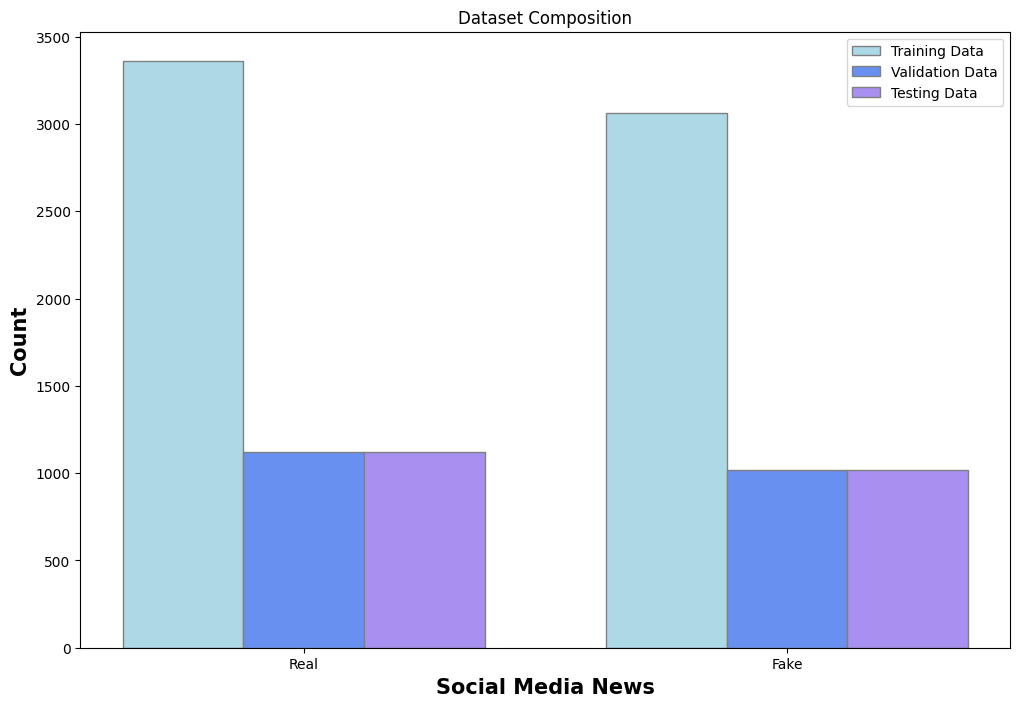

time: 255 ms (started: 2023-12-13 02:06:38 +00:00)


In [ ]:
a= train['label'].value_counts()
a_species = a.index
a_count = a.values

b= val['label'].value_counts()
b_species = b.index
b_count = b.values

c= test['label'].value_counts()
c_species = c.index
c_count = c.values

#plt.bar(a_species, a_count, color = 'lightgreen', label='Training Data')
#plt.bar(b_species, b_count, color = 'red', label='Validation Data')
#plt.bar(c_species, c_count, color = 'purple', label='Testing Data')
#plt.xlabel('News Category')
#plt.ylabel('Count')
#plt.show()

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
#IT = [12, 30, 1, 8, 22]
#ECE = [28, 6, 16, 5, 10]
#CSE = [29, 3, 24, 25, 17]

# Set position of bar on X axis
br1 = np.arange(len(a_count))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, a_count, color ='lightblue', width = barWidth,
        edgecolor ='grey', label='Training Data')
plt.bar(br2, b_count, color ='#6890F0', width = barWidth,
        edgecolor ='grey', label='Validation Data')
plt.bar(br3, c_count, color ='#A890F0', width = barWidth,
        edgecolor ='grey', label='Testing Data')

# Adding Xticks
plt.xlabel('Social Media News', fontweight ='bold', fontsize = 15)
plt.ylabel('Count', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(a_count))],
        ['Real', 'Fake'])
plt.title('Dataset Composition')

plt.legend()
plt.show()

(array([3060.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3360.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

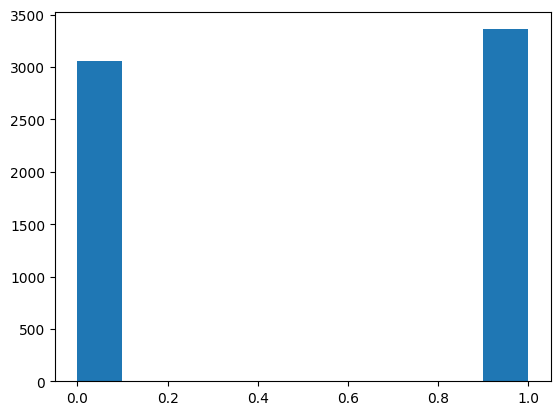

time: 196 ms (started: 2023-12-13 02:06:42 +00:00)


In [ ]:
plt.hist(labels)

##**Define Metrices**

In [ ]:
def print_metrices(pred,true):
    accuracy = accuracy_score(pred,true)
    precision = precision_score(pred, true, average = 'weighted')
    recall = recall_score(pred,true, average = 'weighted')
    f1 = f1_score(pred, true, average = 'weighted')
    print("Accuracy : ",accuracy)
    print("Precison : ",precision)
    print("Recall : ",recall)
    print("F1 : ",f1)
    return accuracy, precision, recall, f1

time: 626 µs (started: 2023-12-13 02:06:45 +00:00)


# Original Baseline for Training, Validation, and Testing

## Method for Training and Validation

In [ ]:
# This method is adapted from the original source-code on:
# https://github.com/parthpatwa/covid19-fake-news-detection/blob/main/ml_baseline.ipynb
def train_val_baseline(pipeline, method_title):
  print(f'Training and Validation of {method_title}')

  # get the starting time
  t0 = time()

  # fit the model with the data
  fit = pipeline.fit(train['tweet'],train['label'])

  pred=pipeline.predict(val['tweet'])
  print(f'Time: {time() - t0} \nPerformance score:')

  # display the elapsed time and performance scores
  print_metrices(pred, val['label'])
  plot_confusion_matrix(confusion_matrix(val['label'], pred),
                        target_names=['fake','real'],
                        normalize = False,
                        title = f'Confusion matix of {method_title} on val data')

  val_ori = pd.read_csv(PATH + 'Constraint_Val.csv')
  val_misclass_df = val_ori[pred!=val['label']]
  val_misclass_df.info()
  val_misclass_df.to_csv(PATH + f'{method_title}_val_misclassified.csv', index=False)

time: 775 µs (started: 2023-12-13 03:48:17 +00:00)


## Method for Testing

In [ ]:
# This method is adapted from the original source-code on:
# https://github.com/parthpatwa/covid19-fake-news-detection/blob/main/ml_baseline-test.ipynb
def test_baseline(pipeline, method_title):
  print(f'Testing Baseline of {method_title}')

  # get the starting time
  t0 = time()

  # fit the model with the data
  fit = pipeline.fit(train['tweet'],train['label'])

  pred=pipeline.predict(test['tweet'])

  # display the elapsed time and performance scores
  print(f'Time: {time() - t0} \nPerformance score:')

  print_metrices(pred, test['label'])
  plot_confusion_matrix(confusion_matrix(val['label'], pred),
                        target_names=['fake','real'],
                        normalize = False,
                        title = f'Confusion matix of {method_title} on Test data')

  test_ori = pd.read_csv(PATH + 'Constraint_Test.csv')
  test_misclass_df = test_ori[pred!=test['label']]
  test_misclass_df.info()
  test_misclass_df.to_csv(PATH + f'{method_title}_test_misclassified.csv', index=False)

time: 818 µs (started: 2023-12-13 03:48:12 +00:00)


## Gradient Boosting

Training and Validation of GDBT
Time: 3.834578275680542 
Performance score:
Accuracy :  0.8700934579439252
Precison :  0.8725701589046834
Recall :  0.8700934579439252
F1 :  0.8700515862471604


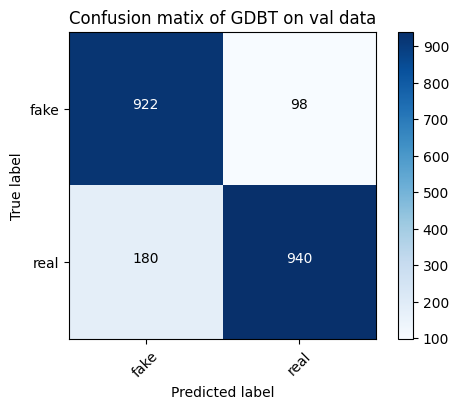

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278 entries, 1 to 2130
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      278 non-null    int64 
 1   tweet   278 non-null    object
 2   label   278 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.7+ KB



Testing Baseline of GDBT
Time: 3.69993257522583 
Performance score:
Accuracy :  0.8696261682242991
Precison :  0.872585146208016
Recall :  0.8696261682242991
F1 :  0.8695982969355982


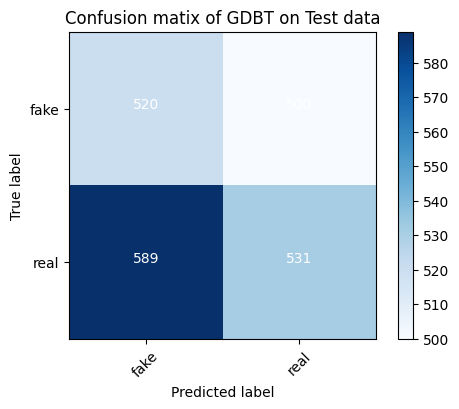

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279 entries, 4 to 2139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      279 non-null    int64 
 1   tweet   279 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.5+ KB
time: 8.05 s (started: 2023-12-10 01:59:03 +00:00)


In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', GradientBoostingClassifier())
    ])

train_val_baseline(pipeline, 'GDBT')
print('\n\n')
test_baseline(pipeline, 'GDBT')

## Decision Tree

Training and Validation of DT
Time: 0.960240364074707 
Performance score:
Accuracy :  0.8542056074766355
Precison :  0.854238134506139
Recall :  0.8542056074766355
F1 :  0.8542188824459249


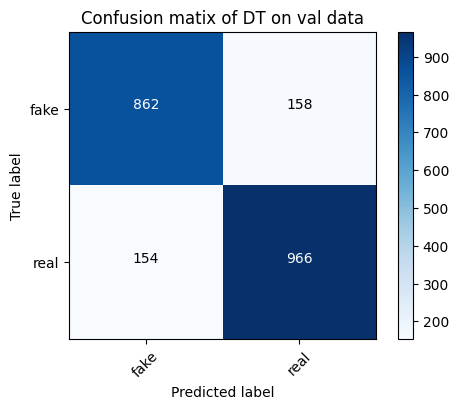

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      312 non-null    int64 
 1   tweet   312 non-null    object
 2   label   312 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.8+ KB



Testing Baseline of DT
Time: 0.9991569519042969 
Performance score:
Accuracy :  0.8607476635514019
Precison :  0.861146037854394
Recall :  0.8607476635514019
F1 :  0.8608384599175029


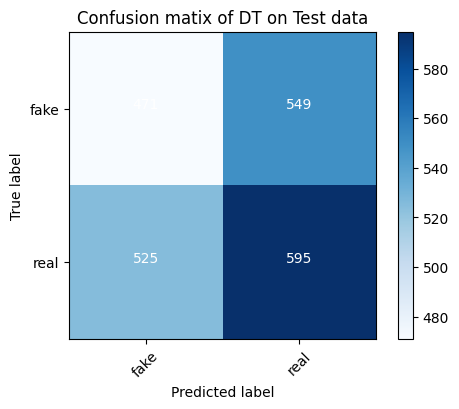

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 5 to 2132
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      298 non-null    int64 
 1   tweet   298 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.0+ KB
time: 3.44 s (started: 2023-12-10 01:59:11 +00:00)


In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', tree.DecisionTreeClassifier())
    ])

train_val_baseline(pipeline, 'DT')
print('\n\n')
test_baseline(pipeline, 'DT')

## Multinomial Naive Bayes

Training and Validation of MNB
Time: 0.19496393203735352 
Performance score:
Accuracy :  0.9196261682242991
Precison :  0.9197314065813241
Recall :  0.9196261682242991
F1 :  0.9196498207544862


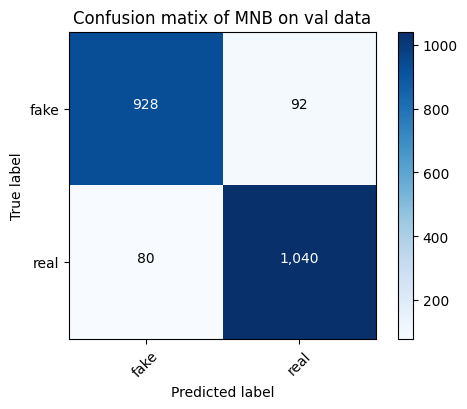

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      172 non-null    int64 
 1   tweet   172 non-null    object
 2   label   172 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.4+ KB



Testing Baseline of MNB
Time: 0.1893160343170166 
Performance score:
Accuracy :  0.9163551401869159
Precison :  0.9167202102803739
Recall :  0.9163551401869159
F1 :  0.9164124126712998


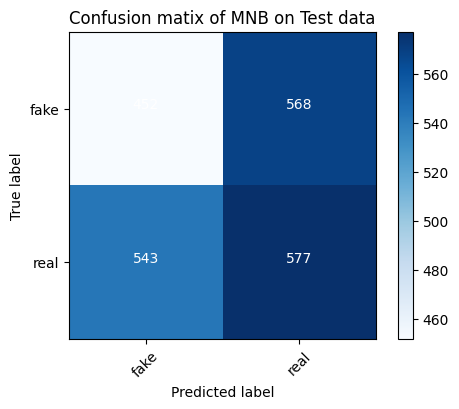

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 5 to 2121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      179 non-null    int64 
 1   tweet   179 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.2+ KB
time: 929 ms (started: 2023-12-12 02:45:35 +00:00)


In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', MultinomialNB(alpha=0.1))
    ])

train_val_baseline(pipeline, 'MNB')
print('\n\n')
test_baseline(pipeline, 'MNB')

## Complement Naive Bayes

Training and Validation of MNC
Time: 0.18835663795471191 
Performance score:
Accuracy :  0.9191588785046729
Precison :  0.9191734322233567
Recall :  0.9191588785046729
F1 :  0.9191643457744798


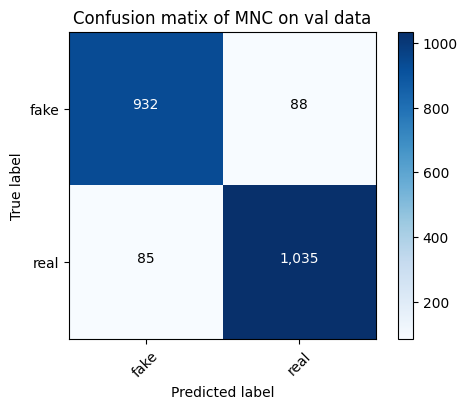

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      173 non-null    int64 
 1   tweet   173 non-null    object
 2   label   173 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.4+ KB



Testing Baseline of MNC
Time: 0.1934514045715332 
Performance score:
Accuracy :  0.9191588785046729
Precison :  0.9192788423780727
Recall :  0.9191588785046729
F1 :  0.9191848824464603


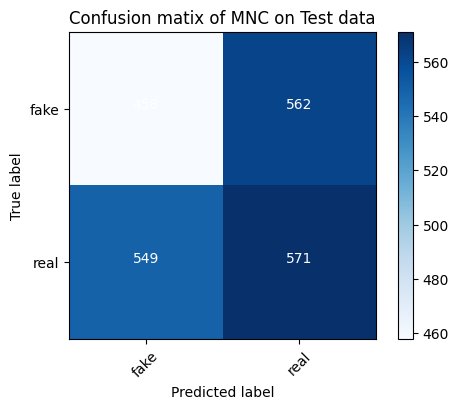

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 5 to 2121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      173 non-null    int64 
 1   tweet   173 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.1+ KB
time: 931 ms (started: 2023-12-12 02:45:54 +00:00)


In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', ComplementNB(alpha=0.1))
    ])

train_val_baseline(pipeline, 'MNC')
print('\n\n')
test_baseline(pipeline, 'MNC')

#Choosing the Right Hyperparameter for Training

## Use Hyperparameter Searching Method

In [ ]:
def hyper_param_search(pipeline, parameter, file_name, cv_range = range(5,11)):
  performance_array = []
  # Perform the grid search
  for i in cv_range:
      grid_search = GridSearchCV(pipeline, parameters, cv=i, n_jobs=2, verbose=1)
      t0 = time()
      grid_search.fit(train['tweet'], train['label'])
      gs_time = time() - t0

      # Display the best parameters, its testing score, and validation score
      gs_best_param = grid_search.best_params_
      gs_best_score = grid_search.best_score_
      gs_val_score = grid_search.score(val['tweet'], val['label'])

      # Print the best parameters and score for each cross-validation value
      print("Cross-validation value: ", i)
      print("Best parameters: ", gs_best_param)
      print("Best Train score: ", gs_best_score)
      print('Validation Score:', gs_val_score)
      print('Runtime:', gs_time)

      # Populate the parameters, scores, and running time for later table
      performance_array.append([i, gs_best_param,
                                gs_best_score,
                                gs_val_score,
                                gs_time])

  # convert the previously collected performance array into Panda DataFrame
  # and arrange the columns
  data_df = pd.DataFrame(performance_array, columns=['k', 'best_param',
                                                     'best_score', 'val_score',
                                                     'time'])

  # Write the DataFrame to a CSV file
  data_df.to_csv(PATH + file_name, index=False)

time: 1.5 ms (started: 2023-12-13 02:06:57 +00:00)


##GradientBoosting

###Without SMOTE

####Finding the best parameters

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

# Define the parameters to be tuned
parameters = {
    'gb__n_estimators': [750, 1000, 1500],
    'gb__learning_rate': [1.0, 0.1, 0.01],
    'gb__subsample': np.arange(0.5, 1.1, 0.1).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'GB_HYPERPARAM.csv')

Fitting 5 folds for each of 63 candidates, totalling 315 fits


KeyboardInterrupt: ignored

time: 24.3 s (started: 2023-12-11 02:52:26 +00:00)


####Pipeline

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE,
                                      learning_rate=0.1, n_estimators=1500,
                                      subsample=0.7999999999999999))
])


time: 615 µs (started: 2023-12-13 03:49:37 +00:00)


####Validation

Training and Validation of GB with Hyperparameter Tuned
Time: 52.65484929084778 
Performance score:
Accuracy :  0.9172897196261682
Precison :  0.9178142425194377
Recall :  0.9172897196261682
F1 :  0.9172467185422214


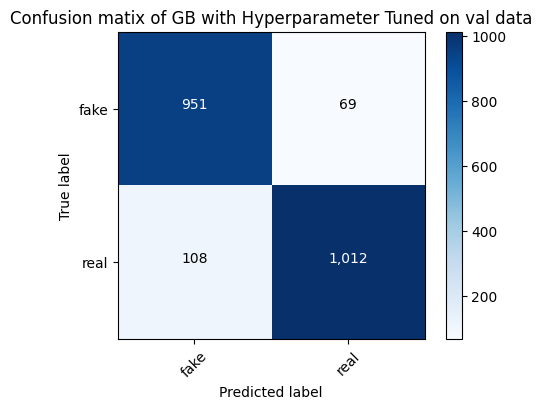

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 1 to 2118
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      177 non-null    int64 
 1   tweet   177 non-null    object
 2   label   177 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.5+ KB
time: 52.9 s (started: 2023-12-13 03:49:41 +00:00)


In [ ]:
train_val_baseline(pipeline, 'GB with Hyperparameter Tuned')


#### Testing

Testing Baseline of GB with Hyperparameter Tuned
Time: 52.57494401931763 
Performance score:
Accuracy :  0.9074766355140187
Precison :  0.907749057566952
Recall :  0.9074766355140187
F1 :  0.9074341629878595


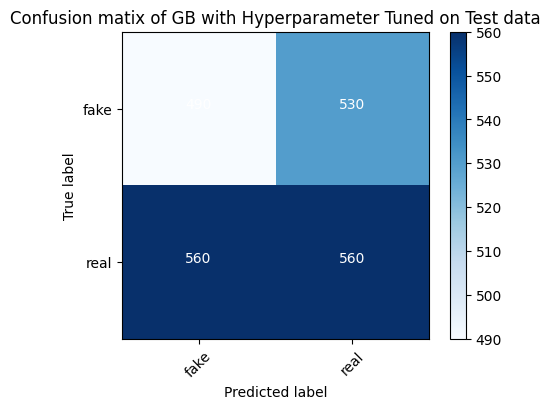

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 5 to 2131
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      198 non-null    int64 
 1   tweet   198 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.6+ KB
time: 52.9 s (started: 2023-12-13 03:50:34 +00:00)


In [ ]:
test_baseline(pipeline, 'GB with Hyperparameter Tuned')

###With SMOTE

####Finding the best parameters

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE,
                       sampling_strategy='minority',
                       n_jobs=-1)),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE,
                                      learning_rate=0.1, n_estimators=1500,
                                      subsample=0.7999999999999999))
])

# Define the parameters to be tuned
parameters = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'all'],
    'sampling__k_neighbors': np.arange(1, 101).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'GB_SMOTE_HYPERPARAM.csv')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


####Pipeline

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE,
                       sampling_strategy='minority',
                       k_neighbors=2)),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE,
                                      learning_rate=0.1, n_estimators=1500,
                                      subsample=0.7999999999999999))
])

time: 573 µs (started: 2023-12-13 03:51:27 +00:00)


####Validation

Training and Validation of GB and SMOTE (k=2) with Hyperparameter Tuned
Time: 55.20177507400513 
Performance score:
Accuracy :  0.9177570093457944
Precison :  0.9185926333150083
Recall :  0.9177570093457944
F1 :  0.9177121583147303


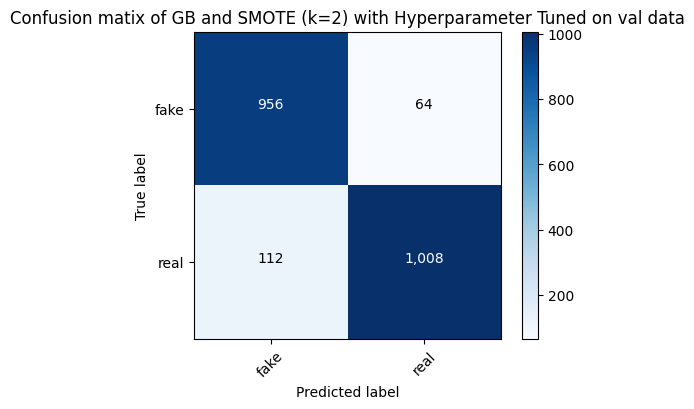

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 1 to 2118
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      176 non-null    int64 
 1   tweet   176 non-null    object
 2   label   176 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.5+ KB
time: 55.6 s (started: 2023-12-13 03:51:27 +00:00)


In [ ]:
train_val_baseline(pipeline, 'GB and SMOTE (k=2) with Hyperparameter Tuned')

####Testing

Testing Baseline of GB and SMOTE (k=2) with Hyperparameter Tuned
Time: 54.708948850631714 
Performance score:
Accuracy :  0.9070093457943925
Precison :  0.9074579341082226
Recall :  0.9070093457943925
F1 :  0.9069619728277016


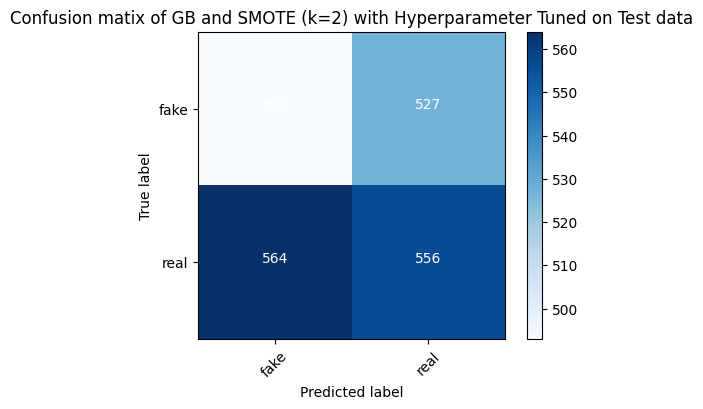

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 5 to 2131
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      199 non-null    int64 
 1   tweet   199 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.7+ KB
time: 55 s (started: 2023-12-13 03:52:23 +00:00)


In [ ]:
test_baseline(pipeline, 'GB and SMOTE (k=2) with Hyperparameter Tuned')

##Decision Tree

###Without SMOTE

####Finding the best parameters

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dt', tree.DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Define the parameters to be tuned
parameters = {
    'dt__min_samples_split': np.arange(2, 21, 2).tolist(),
    'dt__class_weight': [None, 'balanced']
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'DT_HYPERPARAM.csv')

####Pipeline

In [ ]:
# Random State to ensure a reproduceable result
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dt', tree.DecisionTreeClassifier(random_state=RANDOM_STATE,
                                       class_weight=None,
                                       min_samples_split=16))
])


time: 712 µs (started: 2023-12-13 03:56:13 +00:00)


####Validation

Training and Validation of DT with Hyperparameter Tuned
Time: 1.038975477218628 
Performance score:
Accuracy :  0.8546728971962617
Precison :  0.8555866645723711
Recall :  0.8546728971962617
F1 :  0.8548456537807381


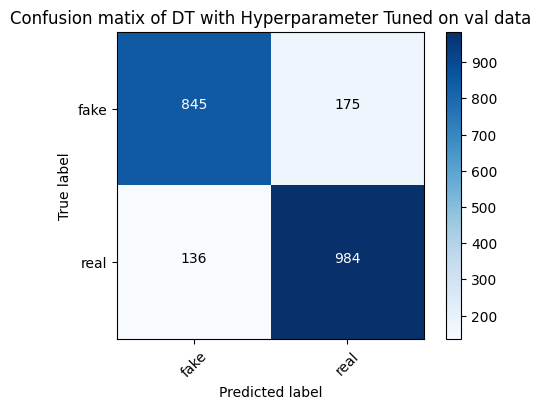

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 1 to 2118
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      311 non-null    int64 
 1   tweet   311 non-null    object
 2   label   311 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.7+ KB
time: 1.35 s (started: 2023-12-13 03:53:18 +00:00)


In [ ]:
train_val_baseline(pipeline, 'DT with Hyperparameter Tuned')


#### Testing

Testing Baseline of DT with Hyperparameter Tuned
Time: 1.038996696472168 
Performance score:
Accuracy :  0.8546728971962617
Precison :  0.8559386698604675
Recall :  0.8546728971962617
F1 :  0.8548931839307617


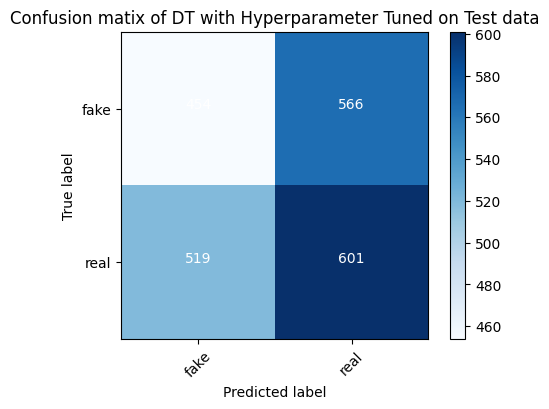

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 5 to 2131
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      311 non-null    int64 
 1   tweet   311 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.3+ KB
time: 1.36 s (started: 2023-12-13 03:56:20 +00:00)


In [ ]:
test_baseline(pipeline, 'DT with Hyperparameter Tuned')

###With SMOTE

####Finding the best parameters

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE, n_jobs=-1)),
    ('dt', tree.DecisionTreeClassifier(random_state=RANDOM_STATE,
                                       min_samples_split=16,
                                       class_weight=None))
])

# Define the parameters to be tuned
parameters = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'all'],
    'sampling__k_neighbors': np.arange(1, 101).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'DT_SMOTE_HYPERPARAM.csv')

####Pipeline

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE,
                       k_neighbors=29,
                       sampling_strategy='minority')),
    ('dt', tree.DecisionTreeClassifier(random_state=RANDOM_STATE,
                                       class_weight=None,
                                       min_samples_split=16))
])


time: 690 µs (started: 2023-12-13 03:57:48 +00:00)


####Validation

Training and Validation of DT and SMOTE (k=29) with Hyperparameter Tuned
Time: 1.4279859066009521 
Performance score:
Accuracy :  0.861214953271028
Precison :  0.8614883652058954
Recall :  0.861214953271028
F1 :  0.8612836855420438


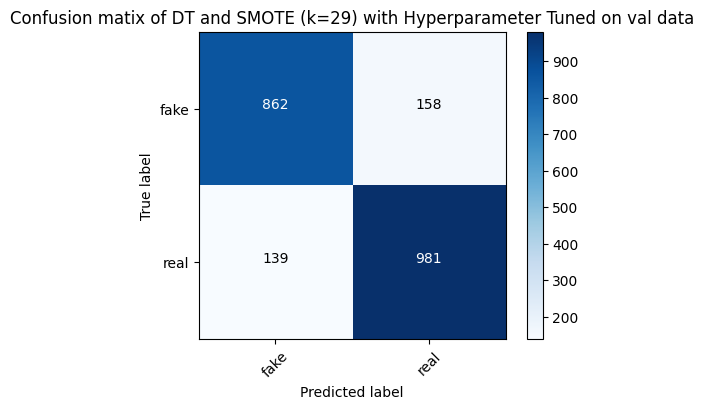

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      297 non-null    int64 
 1   tweet   297 non-null    object
 2   label   297 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.3+ KB
time: 1.74 s (started: 2023-12-13 03:57:57 +00:00)


In [ ]:
train_val_baseline(pipeline, 'DT and SMOTE (k=29) with Hyperparameter Tuned')


#### Testing

Testing Baseline of DT and SMOTE (k=29) with Hyperparameter Tuned
Time: 1.5637853145599365 
Performance score:
Accuracy :  0.8654205607476636
Precison :  0.8663564491217047
Recall :  0.8654205607476636
F1 :  0.8655858337432366


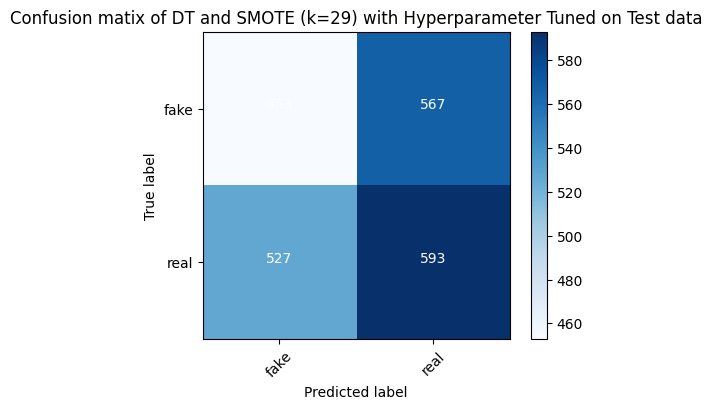

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 5 to 2131
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      288 non-null    int64 
 1   tweet   288 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.8+ KB
time: 1.87 s (started: 2023-12-13 03:58:01 +00:00)


In [ ]:
test_baseline(pipeline, 'DT and SMOTE (k=29) with Hyperparameter Tuned')

##Multinomial Naive Bayes

###Without SMOTE

####Finding the best parameters

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB())
])

# Define the parameters to be tuned
parameters = {
    'mnb__alpha': [100, 10, 1.0, 0.1, 0.01]#,
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'MNB_HYPERPARAM.csv')


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Cross-validation value:  5
Best parameters:  {'mnb__alpha': 0.1}
Best Train score:  0.9185358255451714
Validation Score: 0.9196261682242991
Runtime: 3.436049699783325
Fitting 6 folds for each of 5 candidates, totalling 30 fits
Cross-validation value:  6
Best parameters:  {'mnb__alpha': 0.1}
Best Train score:  0.920404984423676
Validation Score: 0.9196261682242991
Runtime: 2.5468719005584717
Fitting 7 folds for each of 5 candidates, totalling 35 fits
Cross-validation value:  7
Best parameters:  {'mnb__alpha': 0.1}
Best Train score:  0.9196285808640673
Validation Score: 0.9196261682242991
Runtime: 3.003772735595703
Fitting 8 folds for each of 5 candidates, totalling 40 fits
Cross-validation value:  8
Best parameters:  {'mnb__alpha': 0.1}
Best Train score:  0.9185384142383766
Validation Score: 0.9196261682242991
Runtime: 3.3820409774780273
Fitting 9 folds for each of 5 candidates, totalling 45 fits
Cross-validation value:  9
Best

####Pipeline

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB(alpha=0.1))
])


time: 781 µs (started: 2023-12-13 03:59:43 +00:00)


####Validation

Training and Validation of MNB with Hyperparameter Tuned
Time: 0.20806884765625 
Performance score:
Accuracy :  0.9196261682242991
Precison :  0.9197314065813241
Recall :  0.9196261682242991
F1 :  0.9196498207544862


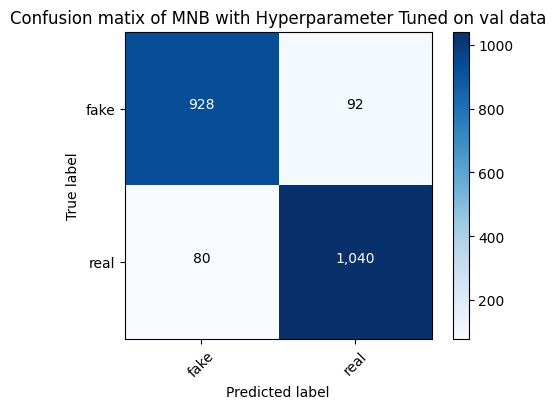

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      172 non-null    int64 
 1   tweet   172 non-null    object
 2   label   172 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.4+ KB
time: 497 ms (started: 2023-12-13 03:59:46 +00:00)


In [ ]:
train_val_baseline(pipeline, 'MNB with Hyperparameter Tuned')


#### Testing

Testing Baseline of MNB with Hyperparameter Tuned
Time: 0.20605230331420898 
Performance score:
Accuracy :  0.9163551401869159
Precison :  0.9167202102803739
Recall :  0.9163551401869159
F1 :  0.9164124126712998


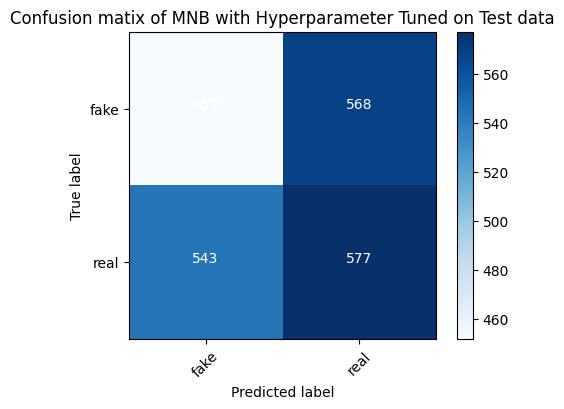

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 5 to 2121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      179 non-null    int64 
 1   tweet   179 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.2+ KB
time: 494 ms (started: 2023-12-13 04:00:56 +00:00)


In [ ]:
test_baseline(pipeline, 'MNB with Hyperparameter Tuned')

###With SMOTE

####Finding the best parameters

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE, n_jobs=-1)),
    ('mnb', MultinomialNB(alpha=0.1))
])

# Define the parameters to be tuned
parameters = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'all'],
    'sampling__k_neighbors': np.arange(1, 101).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'MNB_SMOTE_HYPERPARAM.csv')

####Pipeline

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE,
                       k_neighbors=45,
                       sampling_strategy='minority')),
    ('mnb', MultinomialNB(alpha=0.1))
])


time: 972 µs (started: 2023-12-13 04:03:24 +00:00)


####Validation

Training and Validation of MNB and SMOTE (k=45) with Hyperparameter Tuned
Time: 1.0715339183807373 
Performance score:
Accuracy :  0.9219626168224299
Precison :  0.9219768024032042
Recall :  0.9219626168224299
F1 :  0.9219678944759429


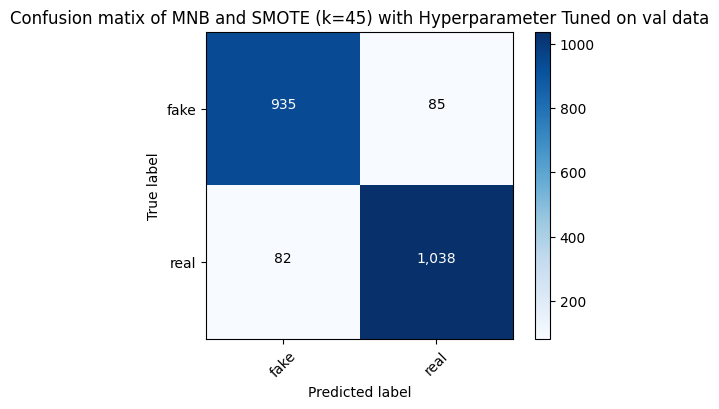

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      167 non-null    int64 
 1   tweet   167 non-null    object
 2   label   167 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.2+ KB
time: 1.36 s (started: 2023-12-13 04:03:29 +00:00)


In [ ]:
train_val_baseline(pipeline, 'MNB and SMOTE (k=45) with Hyperparameter Tuned')


#### Testing

Testing Baseline of MNB and SMOTE (k=45) with Hyperparameter Tuned
Time: 0.5771462917327881 
Performance score:
Accuracy :  0.9210280373831776
Precison :  0.9211469377470615
Recall :  0.9210280373831776
F1 :  0.9210534400777559


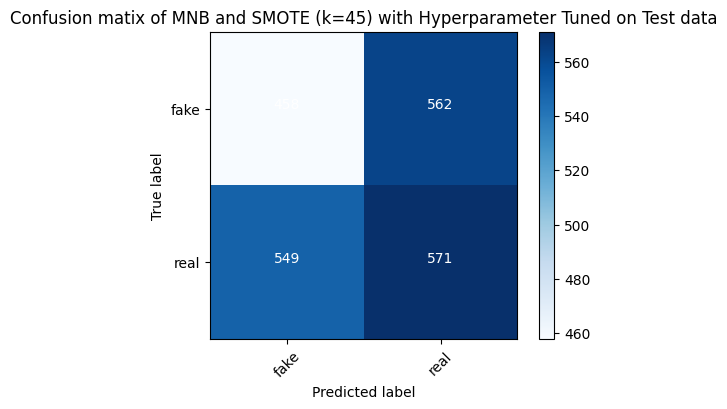

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 5 to 2121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      169 non-null    int64 
 1   tweet   169 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.0+ KB
time: 870 ms (started: 2023-12-13 04:03:33 +00:00)


In [ ]:
test_baseline(pipeline, 'MNB and SMOTE (k=45) with Hyperparameter Tuned')

##Complement Naive Bayes

###Without SMOTE

####Finding the best parameters

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('mnc', ComplementNB())
])

# Define the parameters to be tuned
parameters = {
    'mnc__norm': [True, False],
    'mnc__alpha': [100, 10, 1.0, 0.1, 0.01]
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'MNC_HYPERPARAM.csv')


####Pipeline

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('mnc', ComplementNB(alpha=0.1))
])


time: 623 µs (started: 2023-12-13 04:04:32 +00:00)


####Validation

Training and Validation of MNC Hyperparameter Tuned
Time: 0.19669127464294434 
Performance score:
Accuracy :  0.9191588785046729
Precison :  0.9191734322233567
Recall :  0.9191588785046729
F1 :  0.9191643457744798


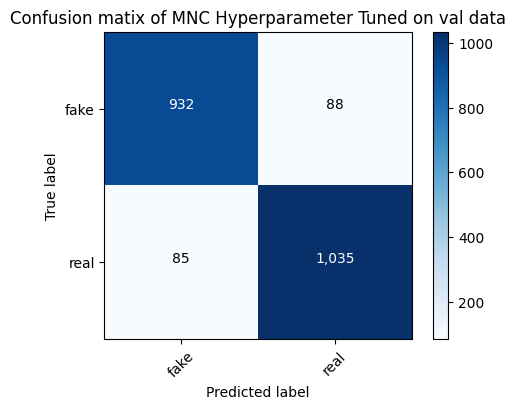

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      173 non-null    int64 
 1   tweet   173 non-null    object
 2   label   173 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.4+ KB
time: 477 ms (started: 2023-12-13 04:04:37 +00:00)


In [ ]:
train_val_baseline(pipeline, 'MNC Hyperparameter Tuned')


#### Testing

Testing Baseline of MNC Hyperparameter Tuned
Time: 0.1975257396697998 
Performance score:
Accuracy :  0.9191588785046729
Precison :  0.9192788423780727
Recall :  0.9191588785046729
F1 :  0.9191848824464603


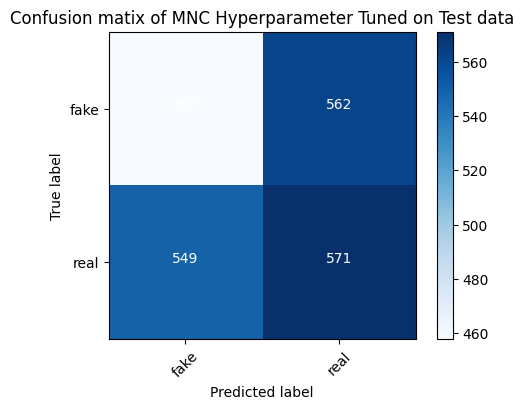

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 5 to 2121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      173 non-null    int64 
 1   tweet   173 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.1+ KB
time: 488 ms (started: 2023-12-13 04:05:13 +00:00)


In [ ]:
test_baseline(pipeline, 'MNC Hyperparameter Tuned')

###With SMOTE

####Finding the best parameters

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE, n_jobs=-1)),
    ('mnc', ComplementNB(alpha=0.1))
])

# Define the parameters to be tuned
parameters = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'all'],
    'sampling__k_neighbors': np.arange(1, 101).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'MNC_SMOTE_HYPERPARAM.csv')

####Pipeline

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE, k_neighbors=45,
                       sampling_strategy='minority')),
    ('mnc', ComplementNB(alpha=0.1))
])


time: 634 µs (started: 2023-12-13 04:05:39 +00:00)


####Validation

Training and Validation of MNC and SMOTE (k=45) Hyperparameter Tuned
Time: 0.5827994346618652 
Performance score:
Accuracy :  0.9219626168224299
Precison :  0.9219768024032042
Recall :  0.9219626168224299
F1 :  0.9219678944759429


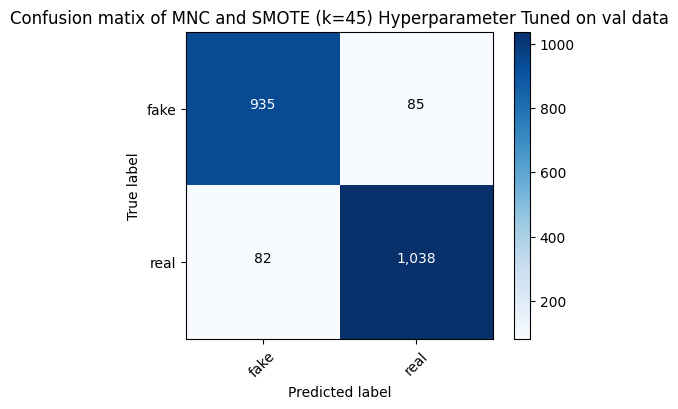

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      167 non-null    int64 
 1   tweet   167 non-null    object
 2   label   167 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.2+ KB
time: 884 ms (started: 2023-12-13 04:05:39 +00:00)


In [ ]:
train_val_baseline(pipeline, 'MNC and SMOTE (k=45) Hyperparameter Tuned')


#### Testing

Testing Baseline of MNC and SMOTE (k=45) Hyperparameter Tuned
Time: 0.550302267074585 
Performance score:
Accuracy :  0.9210280373831776
Precison :  0.9211469377470615
Recall :  0.9210280373831776
F1 :  0.9210534400777559


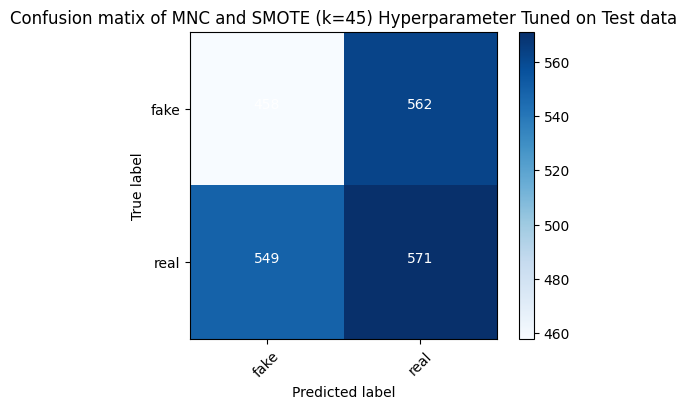

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 5 to 2121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      169 non-null    int64 
 1   tweet   169 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.0+ KB
time: 837 ms (started: 2023-12-13 04:05:40 +00:00)


In [ ]:
test_baseline(pipeline, 'MNC and SMOTE (k=45) Hyperparameter Tuned')